In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from numpy import array
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding

* 데이터 불러오기, 데이터 기본 정보

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/최고존엄민민/DACON_NH 투자증권/ipynb+ csv/data/news_train.csv')
test=pd.read_csv('/content/drive/MyDrive/최고존엄민민/DACON_NH 투자증권/ipynb+ csv/data/news_test.csv')
submission=pd.read_csv('/content/drive/MyDrive/최고존엄민민/DACON_NH 투자증권/ipynb+ csv/data/sample_submission.csv')

In [ ]:
print(train.shape)
print(test.shape)

(118745, 6)
(142565, 6)


In [ ]:
print("train  키:\n", train.keys())

train  키:
 Index(['n_id', 'date', 'title', 'content', 'ord', 'info'], dtype='object')


In [ ]:
print("진짜 뉴스 개수 : {}".format(len(train.loc[train['info']==0])))
print("가짜 뉴스 개수 : {}".format(len(train.loc[train['info']==1])))
print("진짜 뉴스 비율 : {}%".format(round((len(train.loc[train['info']==0])) / len(train.index) * 100, 3)))
print("가짜 뉴스 비율 : {}%".format(round((len(train.loc[train['info']==1])) / len(train.index) * 100, 3)))

진짜 뉴스 개수 : 71813
가짜 뉴스 개수 : 46932
진짜 뉴스 비율 : 60.477%
가짜 뉴스 비율 : 39.523%


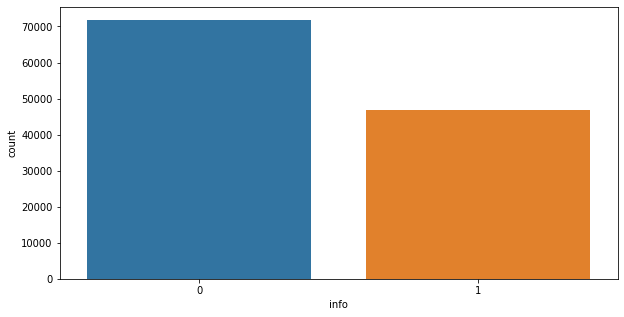

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=train, x="info")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


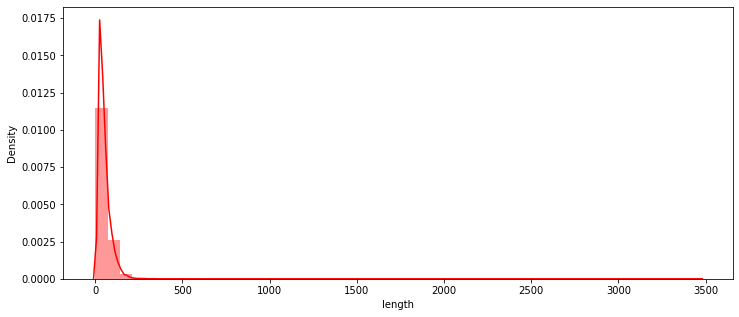

In [ ]:
train['length'] = train['content'].apply(lambda x: len(x))
plt.figure(figsize=(12,5))
sns.distplot(train['length'], color='r')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


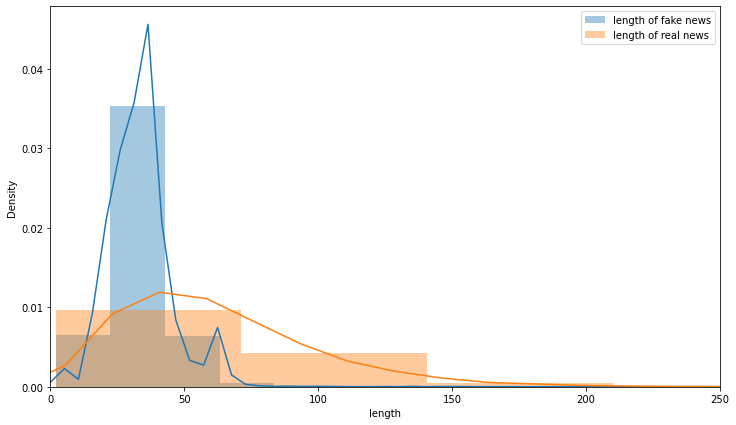

In [ ]:
plt.figure(figsize=(12, 7))
fake = train.loc[train['info']==1]
real = train.loc[train['info']==0]
sns.distplot(fake['length'], label="length of fake news")
sns.distplot(real['length'], label="length of real news")
plt.xlim(0, 250)
plt.legend()

In [ ]:
fake['length'].describe()

count    46932.000000
mean        34.470702
std         20.383651
min          2.000000
25%         27.000000
50%         34.000000
75%         39.000000
max       1022.000000
Name: length, dtype: float64

In [ ]:
real['length'].describe()

count    71813.000000
mean        62.342891
std         43.596060
min          2.000000
25%         34.000000
50%         55.000000
75%         82.000000
max       3469.000000
Name: length, dtype: float64

In [ ]:
def null_check(df):
    null = df.isnull().sum()
    
    null_col=[]

    for i in range(len(df.columns)):
        if (null[i]!=0):
            print(null.index[i],null[i])
            null_col.append(null.index[i])

In [ ]:
null_check(train)

In [ ]:
null_check(test)

* RNN

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train['content'], train['info'], test_size=0.3, shuffle=False, random_state=0)

In [ ]:
X_train=[]
for i in x_train :
    content = re.sub('[^\w\s]', '', i)
    X_train.append(content)
#X_train

X_test=[]
for i in x_test :
    content = re.sub('[^\w\s]', '', i)
    X_test.append(content)
#X_test

In [ ]:
# 토큰화 함수를 이용해 전처리 하는 과정입니다.
token = Tokenizer()             # 토큰화 함수 지정
token.fit_on_texts(X_train)       # 토큰화 함수에 문장 적용
 
#단어의 빈도수를 계산한 결과를 각 옵션에 맞추어 출력합니다. 
 
print("\n단어 카운트:\n", token.word_counts) 
#Tokenizer()의 word_counts 함수는 순서를 기억하는 OrderedDict클래스를 사용합니다.
 
#출력되는 순서는 랜덤입니다. 
print("\n문장 카운트: ", token.document_count)
print("\n각 단어가 몇개의 문장에 포함되어 있는가:\n", token.word_docs)
print("\n각 단어에 매겨진 인덱스 값:\n",  token.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
count = 0
for word, word_count in token.word_counts.items():
    if word_count > 1:
        count += 1
print(count)

63054


In [ ]:
tokenizer = Tokenizer(64000) #hyperparameter
tokenizer.fit_on_texts(X_train)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 부여된 정수 인덱스로 변환
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print("# int_encoding done")

# int_encoding done


In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len_try, (cnt / len(nested_list))*100))

리뷰의 최대 길이 : 423
리뷰의 평균 길이 : 10.332503218199973


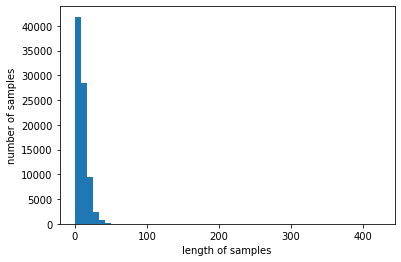

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30 #hyperparameter
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 100.0


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding

# 모델 구축
# 레이어들을 쌓을 모델을 생성
model = Sequential()
model.add(Embedding(64000, 82)) #hyperparameter
model.add(LSTM(82))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 테스트 데이터 손실함수값(val_loss)이 patience회 이상 연속 증가하면 학습을 조기 종료하는 콜백
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# 훈련 도중 테스트 데이터 정확도(val_acc)가 높았던 순간을 체크포인트로 저장해 활용하는 콜백
model_check = ModelCheckpoint('the_best.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=128, callbacks=[early_stop, model_check]) #hyperparameter

650/650 [==============================] - 73s 109ms/step - loss: 0.2252 - acc: 0.8931 - val_loss: 0.0406 - val_acc: 0.9837

Epoch 00001: val_acc improved from -inf to 0.98372, saving model to the_best.h5


In [ ]:
# 정확도 측정
# 출력하면 [loss, acc]
print(model.evaluate(X_test, y_test))

928/928 [==============================] - 75s 80ms/step - loss: 0.0515 - acc: 0.9784
[0.05152255669236183, 0.9784417152404785]


In [ ]:
test_input = test['content']
test_data=[]
for i in test_input :
    content = re.sub('[^\w\s]', '', i)
    test_data.append(content)
#test_data

In [ ]:
# 토큰화 함수를 이용해 전처리 하는 과정입니다.
token = Tokenizer()             # 토큰화 함수 지정
token.fit_on_texts(test_data)       # 토큰화 함수에 문장 적용
 
#단어의 빈도수를 계산한 결과를 각 옵션에 맞추어 출력합니다. 
 
print("\n단어 카운트:\n", token.word_counts) 
#Tokenizer()의 word_counts 함수는 순서를 기억하는 OrderedDict클래스를 사용합니다.
 
#출력되는 순서는 랜덤입니다. 
print("\n문장 카운트: ", token.document_count)
print("\n각 단어가 몇개의 문장에 포함되어 있는가:\n", token.word_docs)
print("\n각 단어에 매겨진 인덱스 값:\n",  token.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 부여된 정수 인덱스로 변환
test_data = tokenizer.texts_to_sequences(test_data)
test_data = pad_sequences(test_data, maxlen=max_len)

In [ ]:
predicted=model.predict(test_data)

In [ ]:
submission.loc[:,'info'] = np.where(predicted> 0.5, 1,0).reshape(-1)

* 진짜뉴스 단어 리스트 만든 후 진짜 뉴스 처리

In [ ]:
real_news= train.query('info == "0"')['content'].unique()

In [ ]:
real_cont=[]
for i in real_news :
    content = re.sub('[^\w\s]', '', i)
    real_cont.append(content)
#real_cont

In [ ]:
# 토큰화 함수를 이용해 전처리 하는 과정입니다.
token = Tokenizer()             # 토큰화 함수 지정
token.fit_on_texts(real_cont)       # 토큰화 함수에 문장 적용
 
#단어의 빈도수를 계산한 결과를 각 옵션에 맞추어 출력합니다. 
 
print("\n단어 카운트:\n", token.word_counts) 
#Tokenizer()의 word_counts 함수는 순서를 기억하는 OrderedDict클래스를 사용합니다.
 
#출력되는 순서는 랜덤입니다. 
print("\n문장 카운트: ", token.document_count)
print("\n각 단어가 몇개의 문장에 포함되어 있는가:\n", token.word_docs)
print("\n각 단어에 매겨진 인덱스 값:\n",  token.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
token.word_docs_reverse = sorted(token.word_docs.items(), 
                              key=lambda item: item[1])

#for key, value in token.word_docs_reverse:
    #print(key, ":", value)

In [ ]:
real_word=["기자","밝혔다","말했다","설명했다","전했다","했다","예정이다","덧붙였다"] #false 121, real 16960

In [1]:
from tqdm import tqdm
test_content = test['content'].values
for idx, sent in enumerate(tqdm(test_content)):
  for i in real_word :
    if i in sent :
      print(sent)
      submission['info'].iloc[idx] = 0 # 같으면 0

* train의 진짜 뉴스와 동일한 test 데이터는 진짜 뉴스 처리

In [ ]:
train_unique_real_sentence = train.query('info == "0"')['content'].unique()
test_unique_sentence = test['content'].unique()

print(len(train_unique_real_sentence))
print(len(test_unique_sentence))
print(len(set(train_unique_real_sentence) & set(test_unique_sentence)))

40370
65827
614


In [ ]:
from tqdm import tqdm

test_content = test['content'].values
for idx, sent in enumerate(tqdm(test_content)) :

    if sent in train_unique_real_sentence: 
        submission['info'].iloc[idx] = 0 # 같으면 0

  0%|          | 0/142565 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 142565/142565 [02:01<00:00, 1174.51it/s]


* train의 가짜뉴스와 동일한 test 데이터는 모두 가짜뉴스 처리

In [ ]:
train_unique_ad_sentence = train.query('info == "1"')['content'].unique()
test_unique_sentence = test['content'].unique()

print(len(train_unique_ad_sentence))
print(len(test_unique_sentence))
print(len(set(train_unique_ad_sentence) & set(test_unique_sentence)))

5794
65827
1973


In [ ]:
from tqdm import tqdm
test_content = test['content'].values
for idx, sent in enumerate(tqdm(test_content)) : #Test 데이터에 있는 모든 content들에 대하여
    if sent in train_unique_ad_sentence: # Train 데이터의 광고성 문구와 같은지 비교
        submission['info'].iloc[idx] = 1 # 같으면 1

  0%|          | 0/142565 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 142565/142565 [00:33<00:00, 4276.69it/s]


In [ ]:
submission.loc[:,["id","info"]].to_csv("sample_submission28.csv", index = False)
submission

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1
